In [2]:
from dgpsi import dgp, kernel, combine, lgp, path, emulator
import numpy as np
import matplotlib.pyplot as plt

We first consider a bi-fidelity case in which the underlying computer model is stationary and thus a simple solution is to do linked GP where the first GP mimics the low fidelity model and the second GP mimics the high fidelity model.

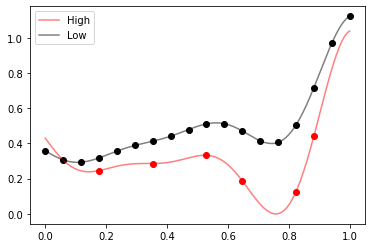

In [2]:
#Creating high and low fidelity functions
n=18
X=np.linspace(0,1.,n)[:,None]
f1= lambda x: ((6*x-2)**2*np.sin(12*x-4)+6)/21
f2= lambda x: 0.6*f1(x)+0.4*(x-0.5)+0.3
Y1=np.array([f1(x) for x in X]).reshape(-1,1)
Y2=np.array([f2(x) for x in X]).reshape(-1,1)
Y1[np.array([0,1,2,4,5,7,8,10,12,13,16,17]),:]=np.nan
Xt=np.linspace(0,1.,200)[:,None]
Yt1=np.array([f1(x) for x in Xt]).flatten()
Yt2=np.array([f2(x) for x in Xt]).flatten()
plt.plot(Xt,Yt1,color='r',alpha=0.5)
plt.plot(Xt,Yt2,color='black',alpha=0.5)
plt.scatter(X,Y1,color='r')
plt.scatter(X,Y2,color='black')
plt.legend(["High","Low"])

In [3]:
#Construct linked GP stucture. We have the global input connected to the GP node in the second layer to inform the second GP that the high-fidelity output also relates to the global input.
layer1=[kernel(length=np.array([.5]),name='sexp',scale_est=1,input_dim=np.arange(1))]
layer2=[kernel(length=np.array([0.5,0.5]),name='sexp',scale_est=1,input_dim=np.arange(1))]
all_layer=combine(layer1,layer2)

In [4]:
#Construct data and the linked GP object
X0=[[X],[Y2[~np.isnan(Y1)].reshape(-1,1)]]
Y0=[[Y2],[Y1[~np.isnan(Y1)].reshape(-1,1)]]
Z0=[[None],[X[~np.isnan(Y1)].reshape(-1,1)]]
m0=lgp(X0,Y0,all_layer,Z0)

In [5]:
#Train linked GP model
m0.train()

Layer 2: Node 1: 100%|██████████| 2/2 [00:00<00:00, 50.22it/s]


In [6]:
#Make predictions
z=np.linspace(0,1,200)[:,None].reshape(-1,1)
gp1=m0.all_layer[0][0]
mu1,v1=gp1.gp_prediction(x=z,z=None)
mu,var=m0.predict(x=z,z=[[None],[z]])

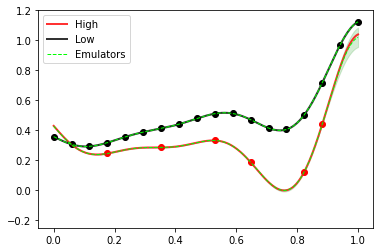

In [7]:
#Draw predictions from both fidelity emulators
s=np.sqrt(var.T)
u=mu.T+2*s
l=mu.T-2*s
s2=np.sqrt(v1.T)
u2=mu1.T+2*s2
l2=mu1.T-2*s2
plt.plot(Xt,Yt1,color='r',alpha=0.8,lw=2)
plt.ylim((-0.25, 1.2)) 
plt.plot(Xt,Yt2,color='black',alpha=0.8,lw=2)
plt.scatter(X,Y1,color='r')
plt.scatter(X,Y2,color='black')
p=plt.plot(z,mu.T,'--',color='lime',alpha=1,lw=1)
p=plt.plot(z,mu1.T,'--',color='lime',alpha=1,lw=1)
plt.fill_between(Xt.flatten(), l.flatten(), u.flatten(), color='tab:green', alpha=0.2)
plt.fill_between(Xt.flatten(), l2.flatten(), u2.flatten(), color='tab:green', alpha=0.2)
plt.legend(["High","Low","Emulators"])

We now consider a bi-fidelity case in which the underlying computer model is non-stationary

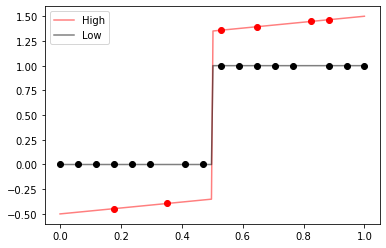

In [3]:
#Creating high and low fidelity functions
n=18
X=np.linspace(0,1.,n)[:,None]
f1= lambda x: 0.3*x-0.5 if x<0.5 else 0.3*x+1.2
f2= lambda x: 0 if x<0.5 else 1.
Y1=np.array([f1(x) for x in X]).reshape(-1,1)
Y2=np.array([f2(x) for x in X]).reshape(-1,1)
Y1[np.array([0,1,2,4,5,7,8,10,12,13,16,17]),:]=np.nan
Y2[np.array([6,14]),:]=np.nan
Xt=np.linspace(0,1.,200)[:,None]
Yt1=np.array([f1(x) for x in Xt]).flatten()
Yt2=np.array([f2(x) for x in Xt]).flatten()
plt.plot(Xt,Yt1,color='r',alpha=0.5)
plt.plot(Xt,Yt2,color='black',alpha=0.5)
plt.scatter(X,Y1,color='r')
plt.scatter(X,Y2,color='black')
plt.legend(["High","Low"])

We first construct a four-layers DGP structure (with 2 effective two-layered DGPs) where the first two layers emulating the low fidelity model and the last two layers emulating the relationship between the output of low fidelity model and that of the high fidelity. We have the global input connected to the node in the third layer to inform the second DGP that the output also relates to the global input.

In [4]:
layer1=[kernel(length=np.array([0.5]),name='sexp')]
layer2=[kernel(length=np.array([0.5]),name='sexp',scale_est=1)]
layer3=[kernel(length=np.array([4,4]),name='sexp',connect=np.arange(1))]
layer4=[kernel(length=np.array([4]),name='sexp',scale_est=1)]
all_layer=combine(layer1,layer2,layer3,layer4)

In [5]:
#Construct explicitly the output of each layer (first layer with nan, second layer with low fidelity observations, third layer with nan, and fourth layer with observations from the high fidelity model). Second and final layer outputs have missingness denoted by nan because the low and high fidelity models are not evaluated at the same input positions.
Y=[np.full((len(Y2),1),np.nan),Y2,np.full((len(Y2),1),np.nan),Y1]
#Y=[Y1,Y2,np.full((len(Y2),1),np.nan),Y1]
m=dgp(X,Y,all_layer)

In [6]:
#Train with 500 SEM steps
m.train(N=500)

Iteration 500: Layer 4: 100%|██████████| 500/500 [00:55<00:00,  8.98it/s]


In [7]:
#Construct emulator
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)

In [8]:
#Make predictions for both low and high fidelity models
z=np.linspace(0,1,200)[:,None].reshape(-1,1)
ker1=emu.all_layer[0][0]
ker2=emu.all_layer[1][0]
mu1,v1=ker1.gp_prediction(x=z,z=None)
mu2,v2=ker2.linkgp_prediction(m=mu1.reshape(-1,1),v=v1.reshape(-1,1),z=None)
mu,var=emu.predict(z, N=50, method='mean_var')

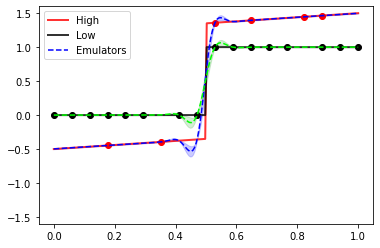

In [9]:
#Draw prediction for the high fidelity model
s=np.sqrt(var.T)
u=mu.T+2*s
l=mu.T-2*s
s2=np.sqrt(v2.T)
u2=mu2.T+2*s2
l2=mu2.T-2*s2
plt.plot(Xt,Yt1,color='r',alpha=0.8,lw=2)
plt.plot(Xt,Yt2,color='black',alpha=0.8,lw=2)
plt.scatter(X,Y1,color='r')
plt.scatter(X,Y2,color='black')
plt.ylim(-1.6,1.6)
p=plt.plot(z,mu.T,'--',color='blue',alpha=1,lw=1.5)
p=plt.plot(z,mu2.T,'--',color='lime',alpha=1,lw=1.5)
plt.fill_between(Xt.flatten(), l.flatten(), u.flatten(), color='blue', alpha=0.2)
plt.fill_between(Xt.flatten(), l2.flatten(), u2.flatten(), color='tab:green', alpha=0.2)
plt.legend(["High","Low","Emulators",])

We now construct a slightly different four-layers DGP structure, in which we set the output of first layer to the output of high fidelity model (i.e., a partially observed layer output) rather than completely latent this is because the outputs of high and low fidelity models are inter-related and we incoporate some information on high-fidelity model to the 2-layered DGP model for the low-fidelity model. 

In [10]:
layer1=[kernel(length=np.array([0.5]),name='sexp')]
layer2=[kernel(length=np.array([1,5]),name='sexp',scale_est=1,connect=np.arange(1))]
layer3=[kernel(length=np.array([1,5]),name='sexp',connect=np.arange(1))]
layer4=[kernel(length=np.array([1]),name='sexp',scale_est=1)]
all_layer=combine(layer1,layer2,layer3,layer4)

In [11]:
#Construct explicitly the output of each layer (first layer with high-fidelity observations, second layer with low fidelity observations, third layer with nan, and fourth layer with observations from the high fidelity model). All layer outputs have missingness denoted by nan because the low and high fidelity models are not evaluated at the same input positions.
Y=[Y1,Y2,np.full((len(Y2),1),np.nan),Y1]
m=dgp(X,Y,all_layer)

In [12]:
#Train with 500 SEM steps
m.train(N=500)

Iteration 500: Layer 4: 100%|██████████| 500/500 [00:47<00:00, 10.51it/s]


In [13]:
#Construct emulator
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)

In [14]:
#Make predictions for both low and high fidelity models
z=np.linspace(0,1,200)[:,None].reshape(-1,1)
ker1=emu.all_layer[0][0]
ker2=emu.all_layer[1][0]
mu1,v1=ker1.gp_prediction(x=z,z=None)
mu2,v2=ker2.linkgp_prediction(m=mu1.reshape(-1,1),v=v1.reshape(-1,1),z=z)
mu,var=emu.predict(z, N=50, method='mean_var')

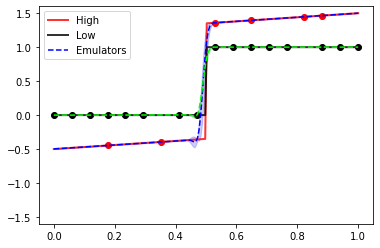

In [15]:
#Draw prediction for the high fidelity model
s=np.sqrt(var.T)
u=mu.T+2*s
l=mu.T-2*s
s2=np.sqrt(v2.T)
u2=mu2.T+2*s2
l2=mu2.T-2*s2
plt.plot(Xt,Yt1,color='r',alpha=0.8,lw=2)
plt.plot(Xt,Yt2,color='black',alpha=0.8,lw=2)
plt.scatter(X,Y1,color='r')
plt.scatter(X,Y2,color='black')
plt.ylim(-1.6,1.6)
p=plt.plot(z,mu.T,'--',color='blue',alpha=1,lw=1.5)
p=plt.plot(z,mu2.T,'--',color='lime',alpha=1,lw=1.5)
plt.fill_between(Xt.flatten(), l.flatten(), u.flatten(), color='blue', alpha=0.2)
plt.fill_between(Xt.flatten(), l2.flatten(), u2.flatten(), color='tab:green', alpha=0.2)
plt.legend(["High","Low","Emulators",])

Remark: the stochastic imputation can sometimes leads to a paramter path that is suboptimal for the emulation, a similar issue to the MLE of GP inference. However, due to the randomness of SI, SI have non-zero probability to jump out of the local optimum. Therefore, a good practice is to run the SEM for several iterations and check the predictive performance, and combined with the trace plot (via the plot method of dgp class) and then reset the initial model paramters for longer training iterations.